In [65]:
bIsGoogleColab = True

In [66]:
if(bIsGoogleColab):
    !umount ./ramdisk
    !mkdir ./ramdisk
    !mount -t tmpfs -o size=5g tmpfs ./ramdisk
    !mkdir ./ramdisk/augmented
    !gdown 1vcJqO1ZChISHubGykn5hQSQGW0RecwdT
    !tar -xf archive_handwrite.tar.xz -C ./ramdisk/
else:
    !sudo -S umount ./ramdisk < ./mypassword.txt
    !mkdir ./ramdisk
    !sudo -S mount -t tmpfs -o size=5g tmpfs ./ramdisk < ./mypassword.txt
    !mkdir ./ramdisk/augmented
    !cp -r archive_handwrite ./ramdisk

[sudo] password for hu: mkdir: cannot create directory ‘./ramdisk’: File exists
[sudo] password for hu: 

In [67]:
if(bIsGoogleColab):
    from google.colab import drive
    drive.mount('/content/drive')
    save_path = '/content/drive/MyDrive/AdvanceProgram/'
else:
    save_path='./'

In [68]:
epochs = 250
batch_size = 8
train_small_radio = 0.05
validation_radio = 0.1

In [69]:
import os
import random
import math
import shutil

In [70]:
base_dir = './ramdisk/archive_handwrite'
train_orig_dir = os.path.join(base_dir,'Train')
train_small_dir = os.path.join(base_dir,'TrainSmall')
train_dir = train_small_dir
test_dir = os.path.join(base_dir, 'Test')
validation_dir = os.path.join(base_dir, 'Validation')

In [71]:
#create smaller train folder
os.mkdir(train_small_dir)

dir_list = os.listdir(train_orig_dir)
for symb_dir in dir_list:
    train_orig_symb_dir = os.path.join(train_orig_dir, symb_dir)
    train_small_symb_dir = os.path.join(train_small_dir, symb_dir)

    #select the val file
    train_orig_file_list = os.listdir(train_orig_symb_dir)
    file_num = len(train_orig_file_list)
    train_small_file_num = math.floor(file_num * train_small_radio)
    train_small_file_list = random.sample(train_orig_file_list, train_small_file_num)
    #print(symb_dir)
    #print(val_file_list)

    #create symbol dir in validation folder
    os.mkdir(train_small_symb_dir)
    #cp selected file to val symbol dir
    for train_small_file in train_small_file_list:
        train_file_orig_path = os.path.join(train_orig_symb_dir, train_small_file)
        shutil.copy(train_file_orig_path, train_small_symb_dir)

In [72]:
#create validation folder
os.mkdir(validation_dir)

dir_list = os.listdir(train_dir)
for symb_dir in dir_list:
    train_symb_dir = os.path.join(train_dir, symb_dir)
    val_symb_dir = os.path.join(validation_dir, symb_dir)

    #select the val file
    train_file_list = os.listdir(train_symb_dir)
    file_num = len(train_file_list)
    val_file_num = math.floor(file_num * validation_radio)
    val_file_list = random.sample(train_file_list, val_file_num)
    #print(symb_dir)
    #print(val_file_list)

    #create symbol dir in validation folder
    os.mkdir(val_symb_dir)
    #move selected file to val symbol dir
    for val_file in val_file_list:
        val_file_orig_path = os.path.join(train_symb_dir, val_file)
        shutil.move(val_file_orig_path, val_symb_dir)




In [73]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [74]:
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 15,
							width_shift_range = 0.1,
							height_shift_range = 0.1,
							shear_range = 0.3,
							zoom_range = 0.3,
							horizontal_flip = False,)

In [75]:
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [76]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (32, 32),
							batch_size = batch_size,
							class_mode ='categorical',
                            color_mode="grayscale",
							#save_to_dir= './ramdisk/augmented',   #not save, make it faster
							#save_prefix='aug',
							#save_format='png'
							)

Found 37532 images belonging to 39 classes.


In [77]:
validation_generator = validation_datagen.flow_from_directory(
							validation_dir,
							target_size = (32, 32),
							batch_size = batch_size,
							class_mode ='categorical',
                            color_mode="grayscale",
							#save_to_dir= './ramdisk/augmented',   #not save, make it faster
							#save_prefix='aug',
							#save_format='png'
							)

Found 4152 images belonging to 39 classes.


<Figure size 640x480 with 0 Axes>

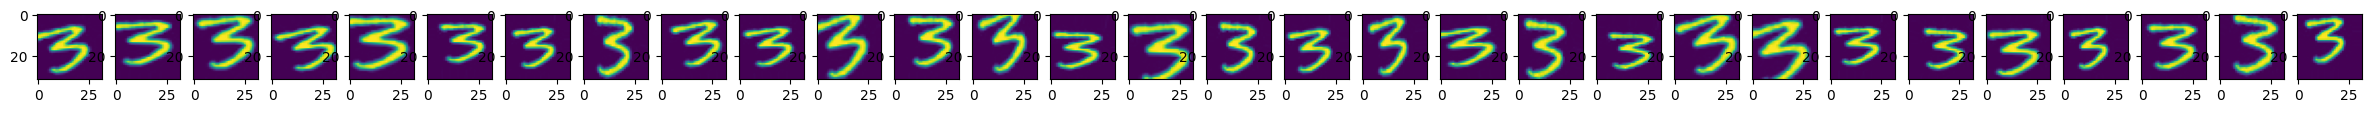

In [78]:
plt.figure()

image_num = 30

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, image_num, figsize=(30, 8)) 

for i in range(image_num) :
  axarr[i].imshow(train_generator[40][0][0])

In [79]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

In [80]:
#simple version
model_simple = models.Sequential()
model_simple.add(layers.Conv2D(10, (3, 3), activation="relu", input_shape = (32,32,1)))
model_simple.add(layers.Flatten())
model_simple.add(layers.Dense(256,activation='relu'))
model_simple.add(layers.Dense(39,activation='sigmoid'))

model_simple.summary()

model_simple.compile(loss='binary_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 10)        100       
                                                                 
 flatten_6 (Flatten)         (None, 9000)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2304256   
                                                                 
 dense_13 (Dense)            (None, 39)                10023     
                                                                 
Total params: 2,314,379
Trainable params: 2,314,379
Non-trainable params: 0
_________________________________________________________________


In [81]:

						
model_adv = models.Sequential()
model_adv.add(layers.Conv2D(32, (3, 3), padding = 'same', activation="relu", input_shape = (32,32,1)))
model_adv.add(layers.MaxPooling2D(pool_size = (2, 2)))
model_adv.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_adv.add(layers.MaxPooling2D(pool_size=(2,2)))
model_adv.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_adv.add(layers.MaxPooling2D(pool_size=(2,2)))
model_adv.add(layers.Dropout(0.25))

model_adv.add(layers.Flatten())
model_adv.add(layers.Dense(128,activation='relu'))
model_adv.add(layers.Dropout(0.2))
model_adv.add(layers.Dense(39,activation='sigmoid'))

model_adv.summary()

model_adv.compile(loss='binary_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 128)       

In [82]:
history = model_simple.fit(
						train_generator, 
                        steps_per_epoch = (train_generator.n)//batch_size,
						epochs = epochs,
                        validation_data = validation_generator,
                        validation_steps = validation_generator.n//batch_size
                        )

Epoch 1/250


2023-05-31 22:17:55.798352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4690/4691 [============================>.] - ETA: 0s - loss: 0.1357 - acc: 0.1631

2023-05-31 22:18:46.335110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4691/4691 [==============================] - 52s 11ms/step - loss: 0.1357 - acc: 0.1631 - val_loss: 0.0976 - val_acc: 0.3131
Epoch 2/250
4691/4691 [==============================] - 51s 11ms/step - loss: 0.0981 - acc: 0.2947 - val_loss: 0.0771 - val_acc: 0.4904
Epoch 3/250
4691/4691 [==============================] - 52s 11ms/step - loss: 0.0878 - acc: 0.3570 - val_loss: 0.0653 - val_acc: 0.5650
Epoch 4/250
4691/4691 [==============================] - 52s 11ms/step - loss: 0.0819 - acc: 0.3991 - val_loss: 0.0589 - val_acc: 0.6161
Epoch 5/250
4691/4691 [==============================] - 52s 11ms/step - loss: 0.0775 - acc: 0.4364 - val_loss: 0.0552 - val_acc: 0.6426
Epoch 6/250
4691/4691 [==============================] - 52s 11ms/step - loss: 0.0746 - acc: 0.4668 - val_loss: 0.0520 - val_acc: 0.6647
Epoch 7/250
4691/4691 [==============================] - 53s 11ms/step - loss: 0.0714 - acc: 0.4957 - val_loss: 0.0498 - val_acc: 0.6823
Epoch 8/250
4691/4691 [==============================

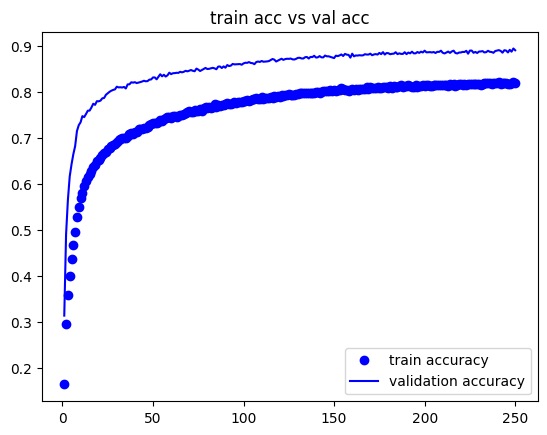

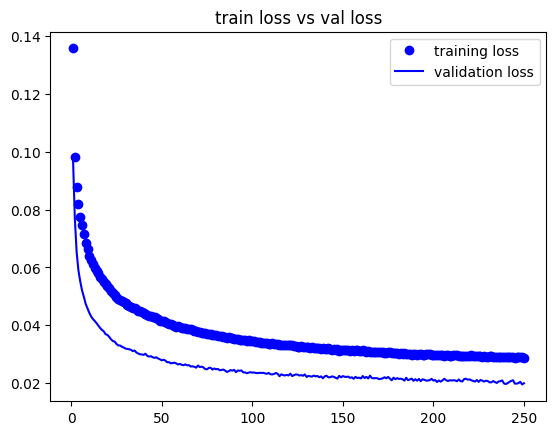

In [83]:
model_simple.save(save_path + 'simple_model.h5')
			
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_step = range(1, len(acc)+1)

plt.plot(epochs_step,acc,'bo',label='train accuracy')
plt.plot(epochs_step,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs_step,loss, 'bo', label ='training loss')
plt.plot(epochs_step,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [84]:
#model_more_train = models.load_model('./ramdisk/simple_model.h5')


In [85]:
history = model_adv.fit(
						train_generator, 
                        steps_per_epoch = (train_generator.n)//batch_size,
						epochs = epochs,
                        validation_data = validation_generator,
                        validation_steps = validation_generator.n//batch_size
                        )

Epoch 1/250


2023-06-01 01:59:58.279496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4689/4691 [============================>.] - ETA: 0s - loss: 0.1711 - acc: 0.0487

2023-06-01 02:00:23.498148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4691/4691 [==============================] - 26s 5ms/step - loss: 0.1710 - acc: 0.0487 - val_loss: 0.1139 - val_acc: 0.0788
Epoch 2/250
4691/4691 [==============================] - 25s 5ms/step - loss: 0.1178 - acc: 0.0857 - val_loss: 0.1085 - val_acc: 0.1818
Epoch 3/250
4691/4691 [==============================] - 25s 5ms/step - loss: 0.1088 - acc: 0.1713 - val_loss: 0.0919 - val_acc: 0.4015
Epoch 4/250
4691/4691 [==============================] - 25s 5ms/step - loss: 0.0982 - acc: 0.2784 - val_loss: 0.0771 - val_acc: 0.4733
Epoch 5/250
4691/4691 [==============================] - 26s 5ms/step - loss: 0.0895 - acc: 0.3477 - val_loss: 0.0676 - val_acc: 0.5409
Epoch 6/250
4691/4691 [==============================] - 26s 5ms/step - loss: 0.0831 - acc: 0.3985 - val_loss: 0.0611 - val_acc: 0.5797
Epoch 7/250
4691/4691 [==============================] - 25s 5ms/step - loss: 0.0776 - acc: 0.4451 - val_loss: 0.0564 - val_acc: 0.6057
Epoch 8/250
4691/4691 [==============================] - 25s

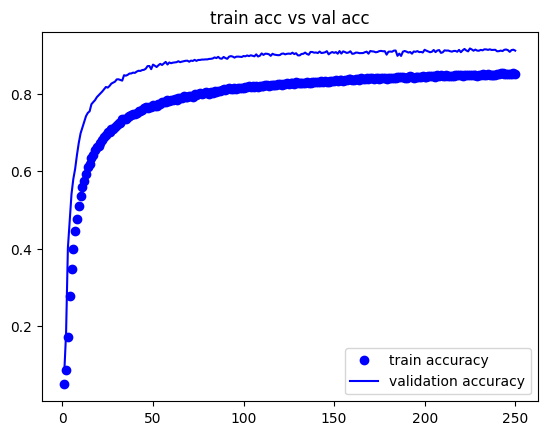

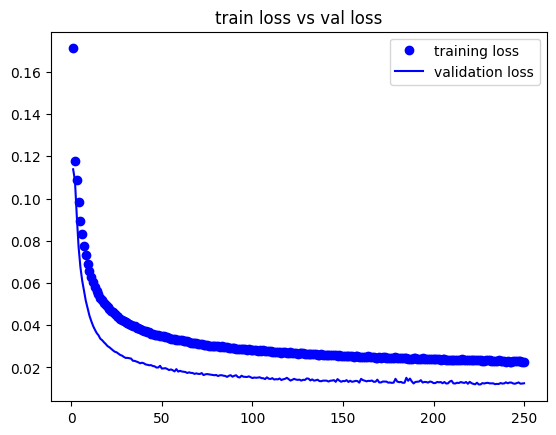

In [86]:
model_adv.save(save_path + 'simple_adv.h5')
			
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_step = range(1, len(acc)+1)

plt.plot(epochs_step,acc,'bo',label='train accuracy')
plt.plot(epochs_step,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs_step,loss, 'bo', label ='training loss')
plt.plot(epochs_step,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [151]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
							test_dir,
							target_size = (32, 32),
							batch_size = 1,#batch_size,
							class_mode ='categorical',
                            color_mode="grayscale",
                            shuffle=False,
							#save_to_dir= './ramdisk/augmented',   #not save, make it faster
							#save_prefix='aug',
							#save_format='png'
							)

test_loss_simple, test_acc_simple = model_simple.evaluate(test_generator, steps = test_generator.n)
print('\ntest simple acc :\n', test_acc_simple)

test_loss_adv, test_acc_adv = model_adv.evaluate(test_generator, steps = test_generator.n)
print('\ntest adv acc :\n', test_acc_adv)

Found 22524 images belonging to 39 classes.
   52/22524 [..............................] - ETA: 1:07 - loss: 0.0040 - acc: 0.9808   

2023-06-01 18:03:50.828846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


22524/22524 [==============================] - 42s 2ms/step - loss: 0.0260 - acc: 0.8675

test simple acc :
 0.8675190806388855
  168/22524 [..............................] - ETA: 20s - loss: 8.7710e-04 - acc: 1.0000

2023-06-01 18:04:33.278934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


22524/22524 [==============================] - 22s 963us/step - loss: 0.0156 - acc: 0.9099

test adv acc :
 0.909873902797699


In [137]:
print('Model         ', 'test loss            ', ' test accuracy ') 
print('Simple        ', test_loss_simple, '   ', test_acc_simple)
print('More Layers   ', test_loss_adv, '   ', test_acc_adv)

Model          test loss              test accuracy 
Simple         0.02598419412970543     0.8675190806388855
More Layers    0.015552742406725883     0.909873902797699


In [189]:
predictions_simple = model_simple.predict(test_generator)
classes_x_simple = np.argmax(predictions_simple,axis=1)

predictions_adv = model_adv.predict(test_generator)
classes_x_adv = np.argmax(predictions_adv,axis=1)

   49/22524 [..............................] - ETA: 1:12

2023-06-01 18:41:59.866797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  168/22524 [..............................] - ETA: 20s

2023-06-01 18:42:45.291147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


22524/22524 [==============================] - 20s 878us/step


In [190]:
class_symb_list = list(test_generator.class_indices.keys())

In [191]:
from tensorflow.math import confusion_matrix

mat_simple = confusion_matrix(classes_x_simple, test_generator.labels)
mat_adv = confusion_matrix(classes_x_adv, test_generator.labels)

In [192]:
def get_PercentMat(mat):
    mat_percent = mat.numpy()
    mat_percent = mat_percent.astype('float64')
    mat_shape = mat_percent.shape
    sample_num_list = []

    for class_index in range(mat_shape[1]):
        total_num = np.sum(mat_percent[:][class_index])
        sample_num_list.append(total_num)
        mat_percent[:][class_index] = mat_percent[:][class_index] / total_num

    return mat_percent

In [193]:
mat_percent_simple = get_PercentMat(mat_simple)
mat_percent_adv = get_PercentMat(mat_adv)


In [194]:
import seaborn as sns

Text(0.5, 146.7222222222222, 'Predicted Values')

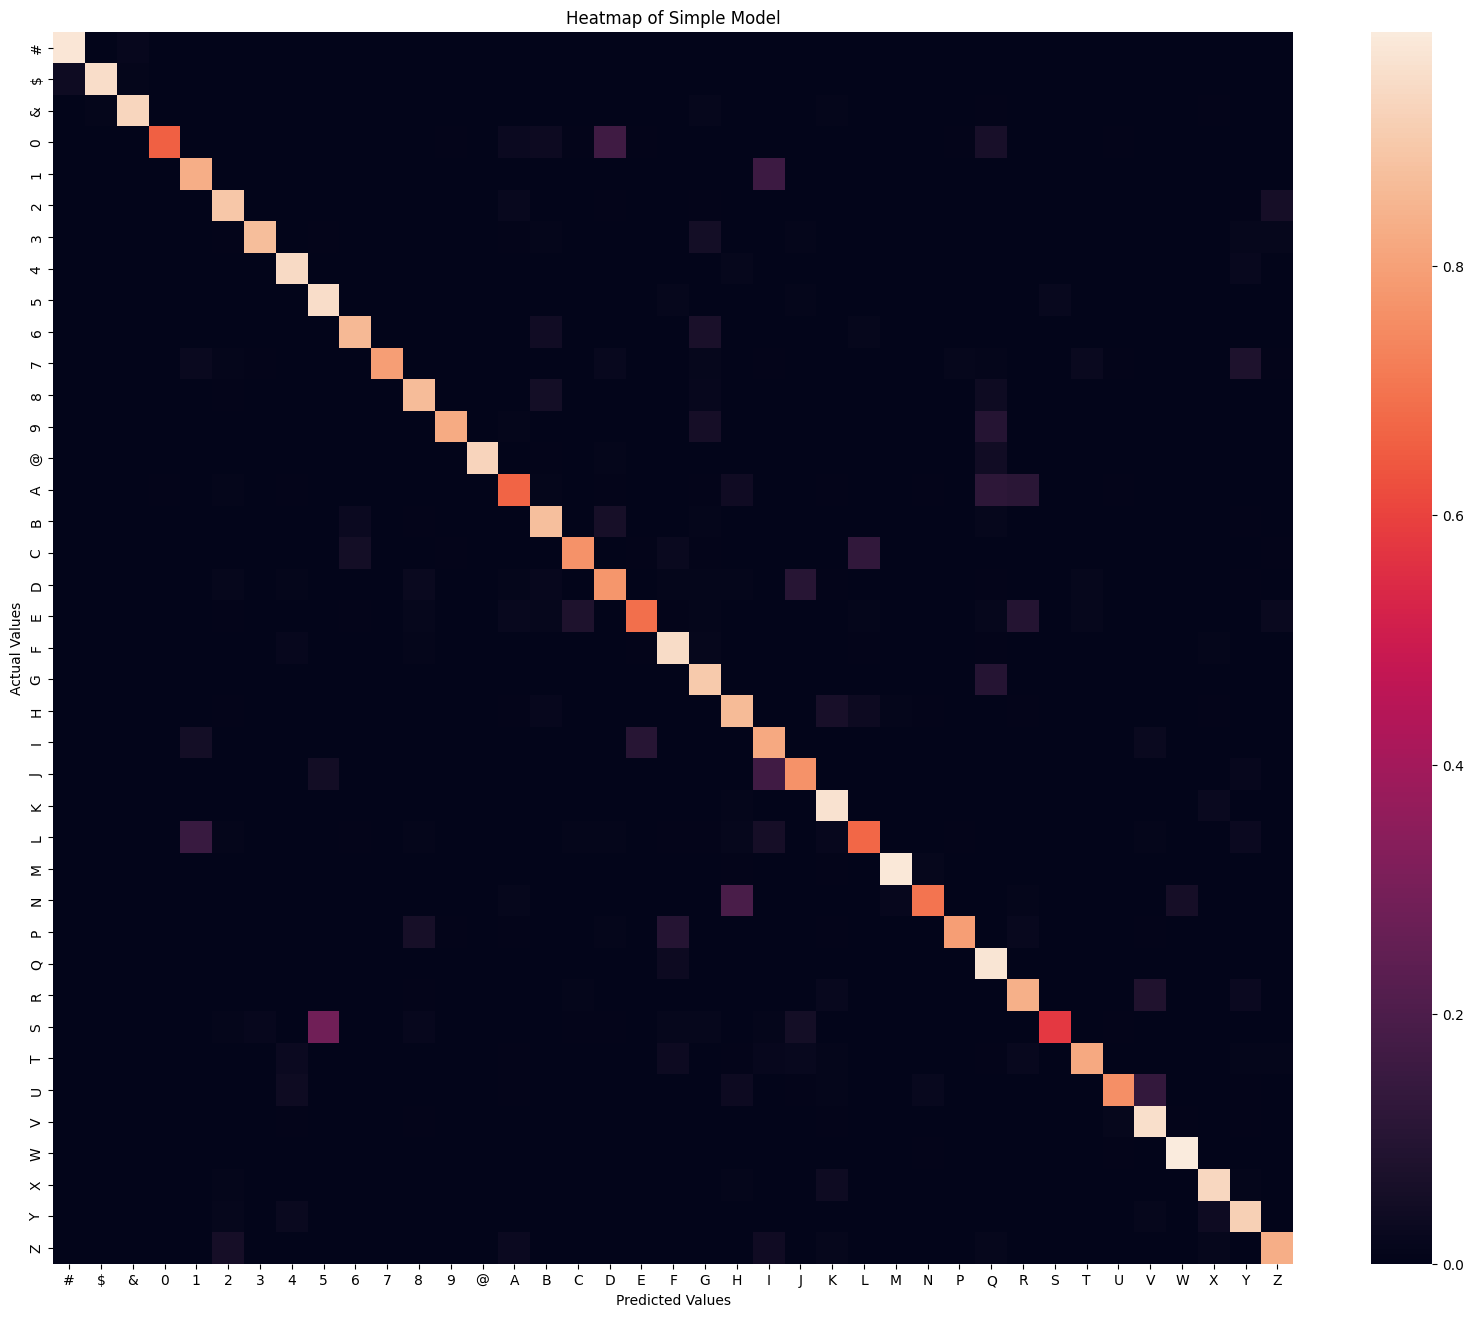

In [195]:
plt.figure(figsize=(20,16))
plt.title('Heatmap of Simple Model')
sns.heatmap(mat_percent_simple, xticklabels=class_symb_list, yticklabels=class_symb_list)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Text(0.5, 146.7222222222222, 'Predicted Values')

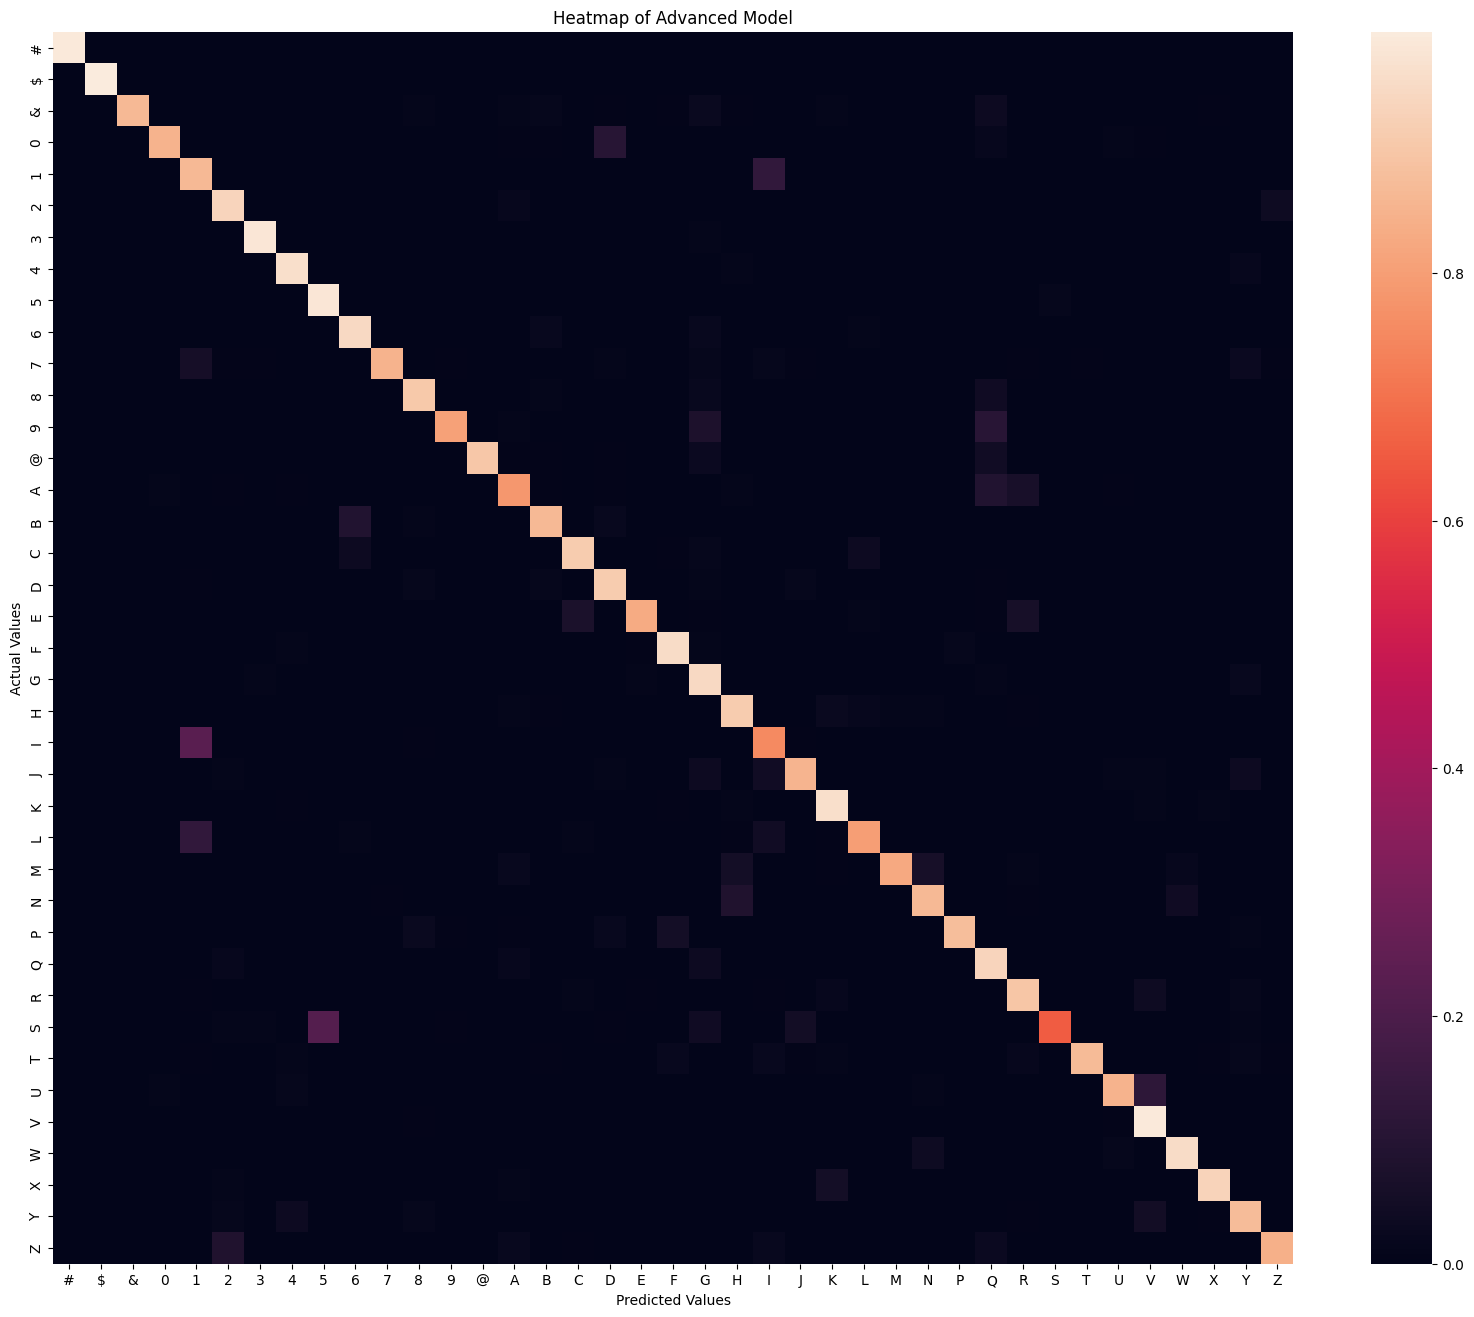

In [196]:
plt.figure(figsize=(20,16))
plt.title('Heatmap of Advanced Model')
sns.heatmap(mat_percent_adv, xticklabels=class_symb_list, yticklabels=class_symb_list)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')